D:\Anaconda\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in double_scalars


theoretical P 0.012
wallbump 791


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:263: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


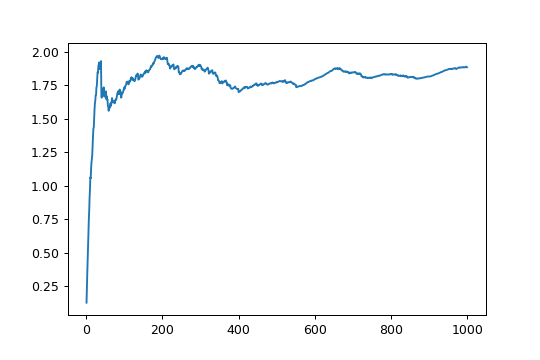

<IPython.core.display.Javascript object>


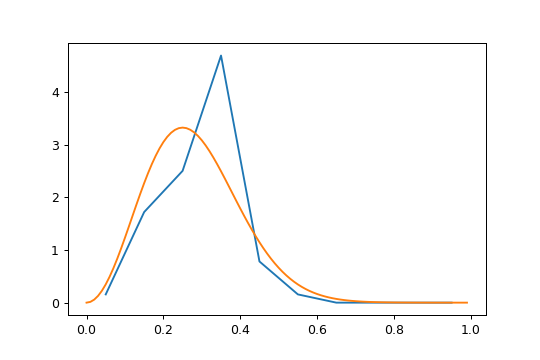

In [1]:
# this is to use PBC to calculate pressure
# actually, no PBC were used. 
# in this version of code. pressure and speed distribution have been fixed

import numpy as np 
import time 
import math
import scipy.spatial
from scipy.spatial import cKDTree as KDTree
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

def kinetic_energy(m, v):
    """
    args:
        m (float): mass of particles
        v (array): velocities of particles,
        assumed to be a 2D array of shape (N, 3)
    returns:
        float: total kinetic energy
    """
    total_vsq = np.einsum('ij,ij', v, v)
    return 0.5*m*total_vsq

def initial_positions(N,radius,L):
    """ 
    Simple helper function to generate fcc positions 
    
    args: 
        N (int): number of particles 
        L (float): side length of cubic box
        radius (float): distance on lattice 
    returns:
        array of shape (N,3) with particle positions on fcc lattice 
     """
    a = radius*np.sqrt(2)*2
    S = list(np.arange(-L/2.,L/2.-a, a))
   
    FCC = list(itertools.product(S,S,S))
    FCC = np.vstack((FCC,
            FCC+a/2.*np.array([1,1,0]),
            FCC+a/2.*np.array([1,0,1]),
            FCC+a/2.*np.array([0,1,1])
            ))
    
    q = np.random.choice(len(FCC),N,replace=False)
    return FCC[q]

def cubic_lattice(tiling, L):
    """
    required for: initialization
    args:
        tiling (int): determines number of coordinates,
        by tiling^3
        L (float): side length of simulation box
    returns:
        array of shape (tiling**3, 3): coordinates on a cubic lattice,
        all between -0.5L and 0.5L
    """
    a=tiling
    ini_pos=np.zeros((a**3,3))
    for i in range(a):
        for j in range(a):
            for k in range(a):
                index=i*a**2+j*a+k
                ini_pos[index][0]=-L/2+L/a*k+L/(2*a)
                ini_pos[index][1]=-L/2+L/a*j+L/(2*a)
                ini_pos[index][2]=-L/2+L/a*i+L/(2*a)
    return ini_pos

def initial_velocities(N, m, T):
    """
    initialize velocities at a desired temperature
    required for: initialization

    args:
        N (int): number of particles
        m (float): mass of particles
        T (float): desired temperature
    returns:
        array: initial velocities, with shape (N, 3)
    """
    velocities = np.random.rand(N,3)-0.5
    #zero the total net velocity
    velocities -= np.average(velocities,axis=0)
    # correct temperature
    current_temp = 2*kinetic_energy(m,velocities)/(3*N)
    velocities *= np.sqrt(T / current_temp)
    return velocities

def eventmap(pos, vel, sigma, L):
    """
    this function calculate the time of each event happens
    input: pos: Nx3, position of all particles
    vel: Nx3, velocities of all particles
    return: tpart: NxN, event map for particle collision
    tw: Nx6, event map for particle wall collision
    """
    N=len(pos) # number of particles
    r=np.zeros((N,N,3)) # r is the displacement of all particles
    v=np.zeros((N,N,3)) # v is relative velocity of all particles
    tpart=np.zeros((N,N)) # particle collision timetable
    # r[i,j]=ri-rj, a vector
    for i in range(N):
        for j in range(N):
            r[i][j]=np.subtract(pos[i],pos[j])
            v[i][j]=np.subtract(vel[i],vel[j])
            vij=np.linalg.norm(v[i][j]) # norm of vij
            rij=np.linalg.norm(r[i][j]) # norm of rij
            delta=(2*np.dot(r[i][j],v[i][j])**2-4*vij**2*(rij**2-sigma**2)) 
            
            # if delta for the quadratic equation is >0, then the two particles will bump.
            if delta>=0: 
                tpart[i][j]=(-2*np.dot(r[i][j],v[i][j])+np.sqrt(delta))/(2*vij**2)
            else:
                tpart[i][j]=5000; # assign a large number
            
    # below is the timetable for walls.
    tw=np.zeros((N,6)) # wall collision timetable
    # this table calculate the time they collide supposing they will bump.
    for i in range(N):
        length_left = np.subtract(pos[i],-L/2)
        tback = np.divide(length_left,-vel[i])
        length_right = np.subtract(L/2,pos[i])
        tforward = np.divide(length_right,vel[i])
        a = [tback,tforward]
        tw[i]=np.reshape(a,[1,6])
    
    return tpart, tw

def comparetime(pos, vel, L):
    """
    this function will judge the min of tpart is smaller or min of twall
    return: mint_smaller is a boolean value. if True, then min of tpart is smaller
    i,j is the coordinates of min of tpart
    iw, jw is the coordinates of min of twall
    smallerT is the smaller T value itself
    """
    N=len(pos)
    [tpart, twall]=eventmap(pos, vel, sigma, L)

    minind_part = np.nanargmin(tpart) # this is the index of munimal value
    mint_part = np.nanmin(tpart) # this is minimal value of tpart
    
    i = minind_part // N # minind=i*N+j  t[i][j] is the smallest
    j = minind_part % N
    if mint_part<0:
        mint_part=5000
        i=0
        j=0
        
    #print('mint_part is ',mint)
    mint_wall = np.min(twall[twall>0])
    #print('mint_wall is ',mint_wall)
    [iw, jw] = np.where(twall==mint_wall)
    
    mint_smaller = mint_part<mint_wall
    smallerT = min(mint_part,mint_wall)
    return mint_smaller, i,j, iw,jw, smallerT

def proce_part(pos, vel, i, j, mint):
    '''
    this function returns pos and vel after particle collision
    '''
    pos = pos+vel*mint
    rij_vec=pos[i]-pos[j]
    rij = np.linalg.norm(rij_vec) # norm of rij_vec
    vij_vec=vel[i]-vel[j]
    vel[i]=vel[i] - (np.dot(rij_vec,vij_vec)/rij)*rij_vec/rij
    vel[j]=vel[j] + (np.dot(rij_vec,vij_vec)/rij)*rij_vec/rij
    #t_pass=(mint)
    return pos, vel

def proce_wall(pos, vel, iw, jw, m, mint_wall):
    '''
    this function returns pos and vel after wall collision
    and momentum change on the wall
    '''
    pos = pos+vel*mint_wall
    b = jw % 3
    vel[iw,b] = -vel[iw,b]
    dmomentum = 2 * np.absolute(vel[iw,b]) * m
    return pos, vel, dmomentum

tilting = 4
N = tilting**3
Lbox = 20
L=Lbox
V = L**3
T = 1.5
mass = 48.0
dt = 0.005
# rc = 3.0 
sigma=0.3 # diameter of the particles. 
#sigma in 0.2-0.6 is optimal. otherwise bumpwall will be too high
k = 1.38*10**-23 # Boltzmann constant

colli=1000 # how many collisions to simulate

# these are reduced units for Ar. 1=3.4A in length, 1=40/6.02*10^-23g= one Ar molecule mass
# 1=1.65*10^-21 in energy, temperature is 1=120K， 1=2.17*10^-12 second

pos = cubic_lattice(tilting, Lbox)
vel = initial_velocities(N,mass,T)


'''nbins = 20
dr = 0.025
speed = np.linalg.norm(vel, axis=-1) # norm of vel
histogram = np.histogram(speed, bins=nbins, range=(0, nbins*dr))
r = (histogram[1] + dr/2)[:-1] # centers of the bins
plt.figure()
plt.plot(r, histogram[0])
'''
tmap=eventmap(pos, vel, sigma, Lbox)

timepassed=[0]
KE=[kinetic_energy(mass,vel)]
p=[]
wall_timer = []
dmom = [0]
timer=0
partbump=0
wallbump=0
dmomentum = 0
print('theoretical P',N*T/V)
vel_storer = []

# run the code colli times
for run in range(1,colli):
    [mint_smaller, i,j, iw,jw, smallerT] = comparetime(pos, vel, L)
    #print('smallerT',smallerT,'run',run)
    if mint_smaller:
        # if collision will happen btw particles, then use proce_part
        [pos, vel] = proce_part(pos, vel, i, j, smallerT)
        vel_storer.append(vel)
        timer = timer+smallerT
        partbump=partbump+1
        #dmomentum = 0
    else:
        # if collision will happen btw particle and wall, then use proce_wall
        [pos, vel, dmomentum] = proce_wall(pos, vel, iw, jw, mass, smallerT)
        timer = timer+smallerT
        wall_timer.append(smallerT)
        #pressure = dmomentum/timer
        dmom.append(dmomentum)
        vel_storer.append(vel)
        
        timer = 0
        wallbump=wallbump+1
        
    #dmom.append(dmomentum)
    #p.append(pressure)
    KE.append(kinetic_energy(mass,vel))
    #print('timepassed run-1',timepassed[run-1])
    timepassed.append(smallerT+timepassed[run-1])


p.insert(0,0)


bumpf=np.divide(range(colli),timepassed) # this is the collision frequency

print('wallbump',wallbump) # this gives how many collision between the part and wall
plt.figure()
plt.plot(bumpf)


# distribution of experiment
nbins = 10
dr = 1/nbins

speed = np.linalg.norm(vel, axis=-1) # norm of vel

histogram = np.histogram(speed, bins=nbins, range=(0, nbins*dr))

prob_dens = histogram[0]/(dr*N) # probability density
r = (histogram[1] + dr/2)[:-1] # centers of the bins

plt.figure()
plt.plot(r, prob_dens)

# distribution predicted by Maxwell
vv = np.divide(range(100),100/(nbins*dr))
fv = [4*np.pi*x**2*(mass/(2*np.pi*T))**1.5*np.exp(-mass*x**2/(2*T)) for x in vv]

plt.plot(vv,fv)



<IPython.core.display.Javascript object>


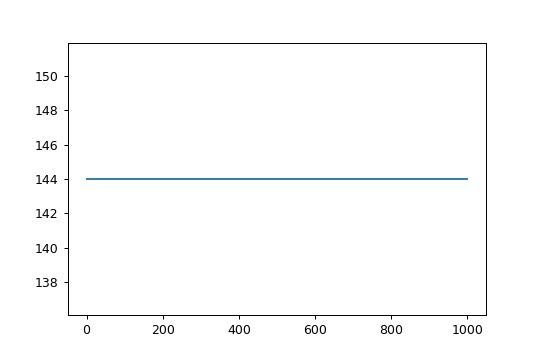

<IPython.core.display.Javascript object>


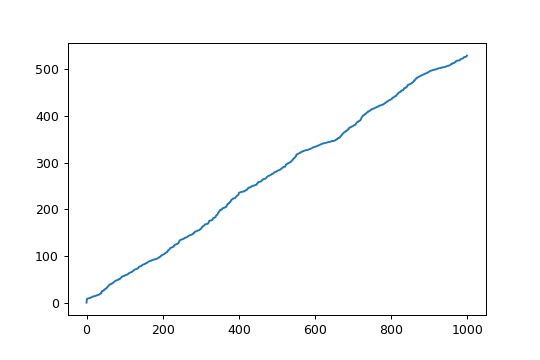

wall timer length 791
bumpf 1.8859623624448891
792 1000
392


<IPython.core.display.Javascript object>


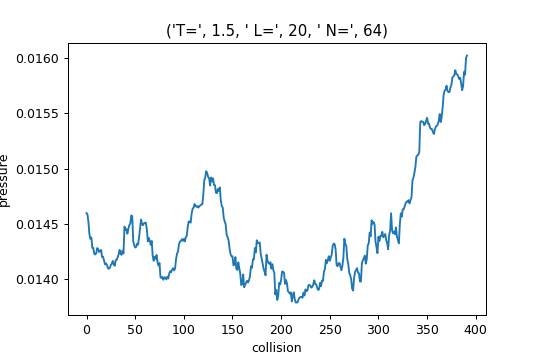

nan
0.2919503571198826 pred 0.28209479177387814
pressure 2.7144583994606664 6.269917713541978
[ 1 11 16 30  5  1  0  0  0  0] 1 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


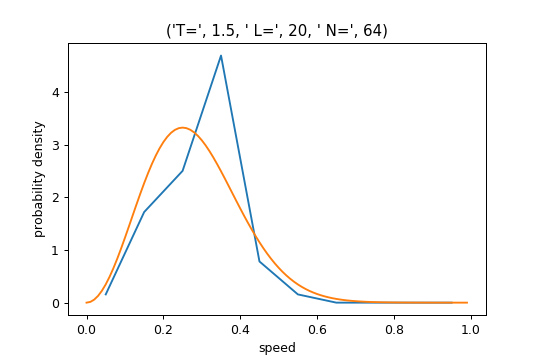

Text(0.5, 1.0, "('T=', 1.5, ' L=', 20, ' N=', 64)")

In [2]:

import matplotlib.pyplot as plt

plt.figure()
plt.plot(KE) # KE is plotted to check if the simulation makes sense

plt.figure()
plt.plot(timepassed) 

print('wall timer length',len(wall_timer))
print('bumpf',bumpf[-1])

avg_p = []
dmomlen = len(dmom)
print(len(dmom),len(timepassed))
for i in range(200,dmomlen-200):
    avg_p.append(sum(dmom[i-199:i+199])/((sum(wall_timer[i-199:i+199]))*6*Lbox**2))
    # the pressure is calculated by p = F/A = (delta p/delta t)/(6*Lbox^2)
    #delta p and delta t are average of 400 terms

plt.figure()
plt.plot(avg_p)
plt.xlabel('collision')
plt.ylabel('pressure')
pltitle = 'T=',T,' L=',L,' N=',N
plt.title(pltitle)
print(np.mean(avg_p[4000::]))

# comparison of the speed
print('exp avg speed',np.average(speed),'pred avg speed',np.sqrt(T/(6*np.pi)))


# distribution of speed
nbins = 10
dr = 1/nbins

speed = np.linalg.norm(vel, axis=-1) # norm of vel

histogram = np.histogram(speed, bins=nbins, range=(0, nbins*dr))

prob_dens = histogram[0]/(dr*N)
r = (histogram[1] + dr/2)[:-1] # centers of the bins

plt.figure()
plt.plot(r, prob_dens)

# distribution predicted by Maxwell
vv = np.divide(range(100),100/(nbins*dr))
fv = [4*np.pi*x**2*(mass/(2*np.pi*T))**1.5*np.exp(-mass*x**2/(2*T)) for x in vv]

plt.plot(vv,fv)
plt.xlabel('speed')
plt.ylabel('probability density')
pltitle = 'T=',T,' L=',L,' N=',N
plt.title(pltitle)

In [11]:
print(np.mean(avg_p[4000::]))

0.014291633016348747
